#  ATOC5860 Application Lab #4 - fft_EPICA (Dome-C Ice Core)
##### Written by Prof. Kay (CU), with "peer-review" by Dr. Elizabeth Maroon (formerly CU, now U-Wisconsin) Dr. Vineel Yettella (ATOC Ph.D. 2018)
##### last updated March 6, 2024 - works with environment culabenv2024

### LEARNING GOALS:
1) Calculate power spectra of a dataset available on a non-uniform temporal grid. Describe the results including an interpretation of the spectral peaks and an assessment of their statistical significance.
2) Contrast applying a Boxcar and a Hanning Window when calculating the power spectra. What are the advantages/disadvantages of these two window types?  What are the implications for the resulting power spectra? 
3) Apply a Hanning Window with various window lengths - What are the advantages/disadvantages of changing the window length and the implications for the resulting power spectra in terms of their statistical significance and temporal precision? 
4) Apply a Hanning Window with various window lengths and use Welch’s method (Welch’s Overlapping Segment Analysis, WOSA).  How does WOSA change the results and why?

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will perform a power spectral analysis of the temperature record from the Dome-C Ice Core, taken at 75 South and 123 East (Jouzel et al. 2007).  The temperature data go back ~800,000 years before present. They are unevenly spaced in time.  The data are available on-line here, courtesy of the NOAA Paleoclimatology Program and World Data Center for Paleoclimatology:
ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt   More information on the data is available at: https://www.ncdc.noaa.gov/paleo-search/study/6080


### Non-exhaustive Questions to guide your analysis:  
**To Start - Execute all code without making any modifications.** 

1) Look at your data and pre-process for FFT analysis: Power spectra analysis assumes that input data are on an evenly spaced grid.  The Dome-C temperature data are not uniformly sampled in time.  Regrid the Dome-C temperature data to a uniform temporal grid in time.  Plot the data before and after re-gridding to make sure the re-gridding worked as expected.

2) Signal and Noise: What is the autocorrelation and e-folding time of your data?  What spectral peaks do you expect to find in your analysis and how much power do you think they will have?  Hint: Think back to the Petit 1999 Vostok ice core dataset discussed in class.

3) Use Boxcar Window to calculate power spectra: Calculate the power spectra using the Numpy method, which assumes a Boxcar window that is the length of your entire dataset.  Graph the power spectrum, the red noise fit to the data, and the 99% confidence interval. What statistically significant spectral peaks did you find?  What do they represent?  

4) Compare Boxcar Window vs. Hanning Window: Calculate the power spectra using the SciPy method.  Compare the results obtained using a Boxcar window that is the length of your entire dataset to those obtained using a Hanning window that is the length of your entire dataset.  Graph the power spectrum, the red noise fit to the data, and the 99% confidence interval. What statistically significant spectral peaks did you find?  What do they represent?  What are the differences between the results obtained using the Boxcar window and the Hanning window?  Is the intuition that you gained by looking at Fort Collins temperatures the same as what you are seeing here with Dome-C temperature records?   Why or Why not?

5) Hanning Window with different window lengths: Using the SciPy method, compare the power spectra obtained using Hanning window with different window lengths.  Graph the power spectra, the red noise fit to the data, and the 99% confidence interval. Did you find any statistically significant spectral peaks?  How does decreasing the window length affect the temporal precision of the spectral peaks and their statistical significance?  Did you find the classic tradeoff between 1) high spectral/temporal resolution but low quality statistics, and 2) high quality statistics but low spectral/temporal resolution?

5) Add WOSA (Welch Overlapping Segment Averaging): Having found what you think is a good balance between precision in the identification of the spectral peaks and statistical significance – Try applying WOSA (Welch Overlapping Segment Averaging) in addition to using the Hanning Window with different window lengths.  How does this change your results?

In [1]:
#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats
import xarray as xr

In [2]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [3]:
ds = xr.open_dataset('/Users/bfarris/Documents/ATOC5860/Homework/homework4/CESM1_LENS_Coupled_Control.cvdp_data.401-2200.nc', decode_times=False)
coupled_nino34 = ds.nino34
coupled_time = ds.time

/Users/bfarris/anaconda3/envs/popy/lib/python3.11/site-packages/xarray/conventions.py:436: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
/Users/bfarris/anaconda3/envs/popy/lib/python3.11/site-packages/xarray/conventions.py:436: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  new_vars[k] = decode_cf_variable(
/Users/bfarris/anaconda3/envs/popy/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 401-01-15 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0401-01-15 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [17]:
hw_index = 100*12 # "Apply Analysis to first 700 years of both control runs"
data_raw=coupled_nino34[0:hw_index]
time_raw=coupled_time[0:hw_index]
var_str = "SST anomaly"
data_units = "C"
data = data_raw
time = time_raw
dt=np.diff(time)
print(dt[0])
dt_regrid=dt[0]

1.0


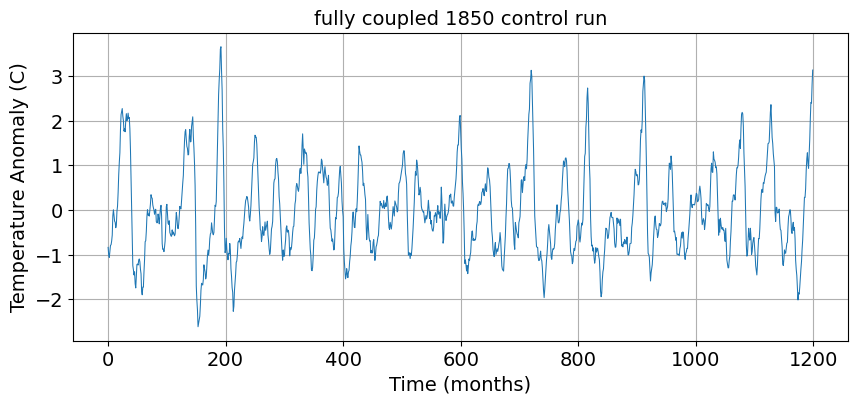

In [18]:
## Plot raw data
fig = plt.figure(figsize=(10,4))
plt.plot(time_raw.values,data_raw, lw=.75)
plt.ylabel(data_units,fontsize=9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (months)',fontsize=14)
plt.ylabel('Temperature Anomaly (C)',fontsize=14)
plt.title("fully coupled 1850 control run",fontsize=14)
plt.grid()
#plt.savefig('XX.pdf', dpi=300, format='png')

In [19]:

## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.99 ## set statistical significance level

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])
### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow=2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function
## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1,red_fit_n)  

SST anomaly lag-1 autocorrelation = 0.97 and Te = 33.0


301
DOF = 4.0


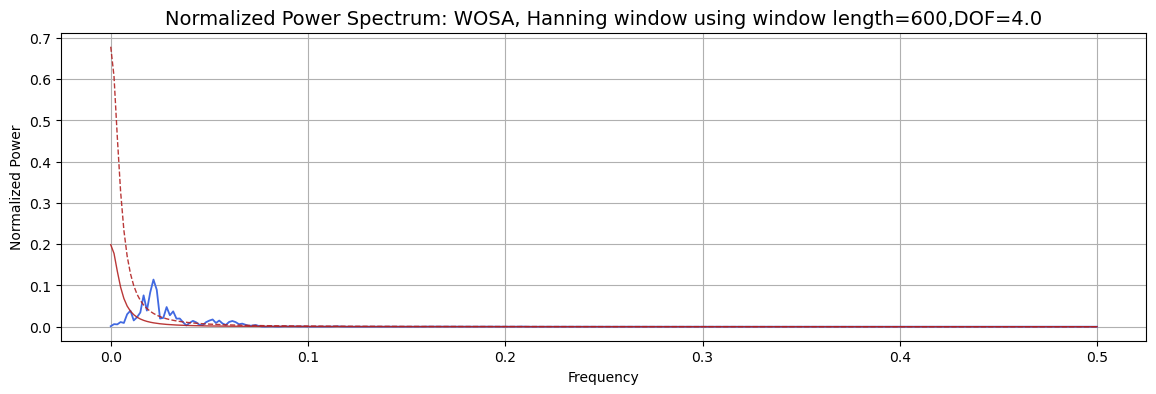

In [20]:
## Use the Hanning Window AND change the length of the data window AND use WOSA (Welch’s Overlapping Segment Analysis)
## How does adding WOSA change the answer??
window_length= 50*12 #50 years, T in months #int(len(data)/4)
T2 = window_length/2
freq_w = np.arange(0.,T2+1.)/window_length
#print(len(freq))
P_welch = signal.welch(data,window='hann',nperseg=window_length);
#print(np.size(P_welch))
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval - we have more DOF
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_welch))
dof_welch=len(data)/(window_length/2)  ### Barnes Eq. 59, factor fw=?, using more of the data so not multiplying by 1.2
print('DOF =',dof_welch)
f_bounds_welch = create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance; 

## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
# plt.ylim(0.0,0.5)
# plt.xlim(0.0,0.06)
plt.grid()
plt.plot(freq_w,P_welch_n, color='royalblue', lw=1.3, label='Hanning,wl='+str(window_length));
plt.plot(freq_w,red_fit_n_welch, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit');
plt.plot(freq_w,f_bounds_welch, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI');
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);

In [21]:
# Find the significant spectral peaks
for i in range(len(P_welch_n)):
    if (P_welch_n[i] - f_bounds_welch[i]) > 5e-03:
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',P_welch_n[i]-f_bounds_welch[i])
        print('at frequency....',freq_w[i])
        print('which in months is approximately...',round((dt_regrid/freq_w[i]))) ## use the regridded regular spacing    

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.023305835307799685
at frequency.... 0.016666666666666666
which in months is approximately... 60
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.0453345547614442
at frequency.... 0.02
which in months is approximately... 50
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.08207720952242975
at frequency.... 0.021666666666666667
which in months is approximately... 46
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.061576223353200246
at frequency.... 0.023333333333333334
which in months is approximately... 43
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.02844870942976518
at frequency.... 0.028333333333333332
which in months is approximately... 35
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.010551301546101143
at frequency.... 0.03
which in months is approximately... 33
##### FOUND IT - spectral peak exceeds r

### SOM

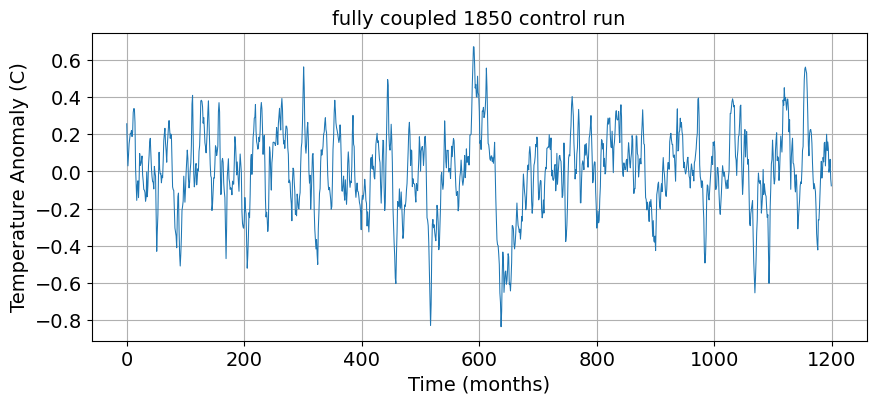

In [22]:
ds2 = xr.open_dataset('/Users/bfarris/Documents/ATOC5860/Homework/homework4/CESM1_LENS_SOM_Control.cvdp_data.277-1001.nc', decode_times=False)
SOM_nino34 = ds2.nino34
SOM_time = ds2.time

hw_index = 100*12 # "Apply Analysis to first 700 years of both control runs"
data_raw=SOM_nino34[0:hw_index]
time_raw=SOM_time[0:hw_index]
var_str = "SST anomaly, SOM"
data_units = "C"
data=data_raw #EDIT THIS
time= time_raw

## Plot raw data
fig = plt.figure(figsize=(10,4))
plt.plot(time_raw.values,data_raw, lw=.75)
plt.ylabel(data_units,fontsize=9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (months)',fontsize=14)
plt.ylabel('Temperature Anomaly (C)',fontsize=14)
plt.title("fully coupled 1850 control run",fontsize=14)
plt.grid()
#plt.savefig('XX.pdf', dpi=300, format='png')

SST anomaly, SOM lag-1 autocorrelation = 0.92 and Te = 12.0
301
DOF = 4.0


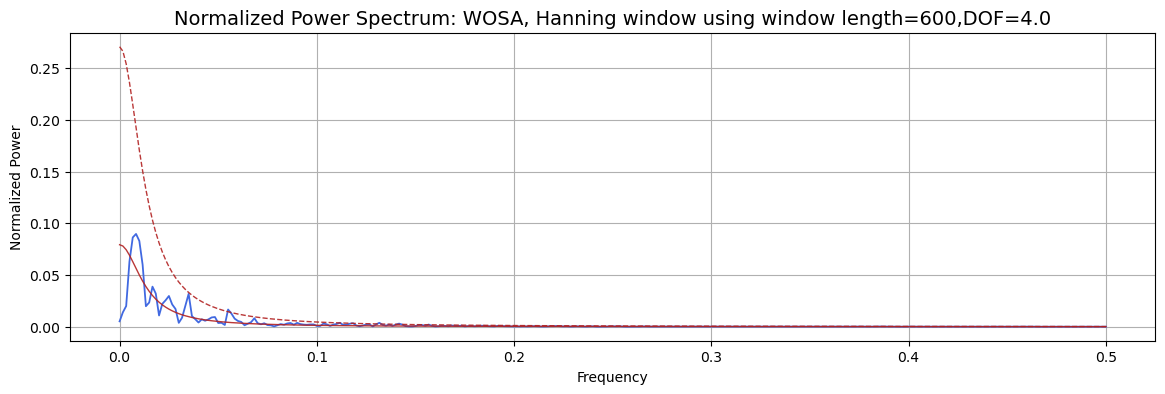

In [23]:
## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.99 ## set statistical significance level

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])
### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow=2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function
## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1,red_fit_n)  

## Use the Hanning Window AND change the length of the data window AND use WOSA (Welch’s Overlapping Segment Analysis)
## How does adding WOSA change the answer??
window_length= 50*12 #50 years, T in months #int(len(data)/4)
T2 = window_length/2
freq_w = np.arange(0.,T2+1.)/window_length
#print(len(freq))
P_welch = signal.welch(data,window='hann',nperseg=window_length);
#print(np.size(P_welch))
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval - we have more DOF
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_welch))
dof_welch=len(data)/(window_length/2)  ### Barnes Eq. 59, factor fw=?, using more of the data so not multiplying by 1.2
print('DOF =',dof_welch)
f_bounds_welch = create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance; 

## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
# plt.ylim(0.0,0.5)
# plt.xlim(0.0,0.06)
plt.grid()
plt.plot(freq_w,P_welch_n, color='royalblue', lw=1.3, label='Hanning,wl='+str(window_length));
plt.plot(freq_w,red_fit_n_welch, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit');
plt.plot(freq_w,f_bounds_welch, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI');
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);

In [16]:
dt=np.diff(time)
print(dt[0])
dt_regrid=dt[0]

# Find the significant spectral peaks
for i in range(len(P_welch_n)):
    if (P_welch_n[i] - f_bounds_welch[i]) > 5e-03:
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',P_welch_n[i]-f_bounds_welch[i])
        print('at frequency....',freq_w[i])
        print('which in months is approximately...',round((dt_regrid/freq_w[i]))) ## use the regridded regular spacing    
    else:
        print('no peaks above 99% CI?!')

1.0
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks above 99% CI?!
no peaks abo